# Parallel Eddy Tracking using xarray

This notebook demonstrates how to iterate through a large xarray dataset in parallel. \
It reads in the xarray dataset from the Intake Catalogue, and then using xarray subsetting commands iterates through each time step while still being able to utilise the memory management of xarray + Dask. \
Using xarray makes it easy to then iterate through the dataset paralle lin time, using e.g. Parallel Clients or Dask Distributed Clients.

Written by A. Wienkers during the EERIE Hackathon using the Eddy ID/Tracking template by Dian. \
Future work will hopefully combine the efficient re-gridding independently developed during the hackathon to eventually super-sample the ICON unstructured mesh onto ~5km regular grid.

**Requirements:**
- Modified version of grid.py into py-eddy-tracker (at ./src/py_eddy_tracker/dataset/grid.py)
  - NOTES:
    - This then requires running "pip install --force-reinstall . " in the py-eddy-tracker directory
    - Due to outdated requirements.txt file, this likely will update matplotlib, and requires running "pip install matplotlib==3.7.1"
- AFW To Do: Submit PR to py-eddy-tracker including this change to grid.py and also to requirements.txt

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import intake
import dask
import pandas as pd
dask.config.set({"array.slicing.split_large_chunks": True}) 

from py_eddy_tracker.dataset.grid import RegularGridDataset
from datetime import datetime, timedelta
from netCDF4 import Dataset

import io
import os

import warnings
warnings.filterwarnings("ignore")

In [3]:
## Start Parallel Client
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
# Note: Could also use Dask Distributed Client
n_cpu = 16

## Load Data from Intake Catalogue

In [4]:
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
expid = 'eerie-control-1950'
gridspec = 'gr025'
cat_regrid = cat['dkrz.disk.model-output.icon-esm-er'][expid]['ocean'][gridspec]
print(list(cat_regrid))

['2d_daily_mean', '2d_daily_square', '2d_monthly_mean', '2d_monthly_square', '5lev_daily_mean', 'eddy_monthly_mean', 'model-level_daily_mean']


In [5]:
ds = cat_regrid['2d_daily_mean'].to_dask()
varname = 'ssh'

In [ ]:
# Use a 1-year subset of the output for demonstration
ds_subset = ds.sel(time=slice('2010-01-01','2011-01-01'))
datearr = [pd.Timestamp(t).to_pydatetime() for t in ds_subset.time.values]

In [8]:
# Directories
scratch = '/scratch/b/b382615/'

datadir = scratch+expid+'/'+gridspec+'/'
outdir = datadir+'/eddytrack/'

if not os.path.exists(outdir):
    os.makedirs(outdir)

## ID Eddies

In [9]:
def detection(ncfile, varname, date): 
    wavelength=700  #choice of spatial cutoff for high pass filter in km
    step_ht=0.005 #intervals to search for closed contours (5mm in this case)
    g = RegularGridDataset(None, "lon", "lat", centered=True, nc4file=ncfile)  # NOTE: Using 'None' for the .nc file path then requires specifying directly the netcdf4 variable in memory
    g.add_uv(varname)
    g.bessel_high_filter(varname, wavelength, order=1)
        
    a, c = g.eddy_identification(varname, "u", "v", 
    date,  # Date of identification
    step_ht,  # step between two isolines of detection (m)
    pixel_limit=(50, 400),  # Min and max pixel count for valid contour
    shape_error=70  # Error max (%) between ratio of circle fit and contour
    )
    return a,c,g


In [10]:
# Parallel function wrapper to the for-loop 
def delayed_ID_and_save(date, tt):
    
    # Load data from xarray into netcdf4 type
    da_ssh = ds_subset.isel(time=tt).ssh
    da_netcdf = Dataset('in-mem-file', mode='r', memory=da_ssh.to_netcdf())
    
    #print('Identifying daily eddies for '+date.strftime('%Y%m%d'))
    a_filtered, c_filtered, g_filtered = detection(da_netcdf,varname,date)
    with Dataset(date.strftime(outdir+"eddyID_anticyclonic_"+date.strftime('%Y%m%d')+".nc"), "w") as h:
        a_filtered.to_netcdf(h)
    with Dataset(date.strftime(outdir+"eddyID_cyclonic_"+date.strftime('%Y%m%d')+".nc"), "w") as h:
        c_filtered.to_netcdf(h)
    del a_filtered
    del c_filtered
    del g_filtered
    del date


In [ ]:
# ID all of the eddies in the ds_subset (here, 1 year) in parallel
with ProcessPoolExecutor(max_workers=n_cpu) as executor:
    results = list(executor.map(delayed_ID_and_save, datearr, range(len(datearr))))

In [12]:
# Test plot the 2nd time slice
da_ssh = ds_subset.isel(time=1).ssh
da_netcdf = Dataset('in-mem-file', mode='r', memory=da_ssh.to_netcdf())
a0, c0, g0 = detection(da_netcdf,varname,datearr[1])


No filtering above 85.000000 degrees of latitude


In [13]:
def start_axes(title):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_axes([0.03, 0.03, 0.90, 0.94])
    ax.set_xlim(0,360), ax.set_ylim(-75,75)
    ax.set_aspect("equal")
    ax.set_title(title, weight="bold")
    return ax


def update_axes(ax, mappable=None):
    ax.grid()
    if mappable:
        plt.colorbar(mappable, cax=ax.figure.add_axes([0.94, 0.05, 0.01, 0.9]))


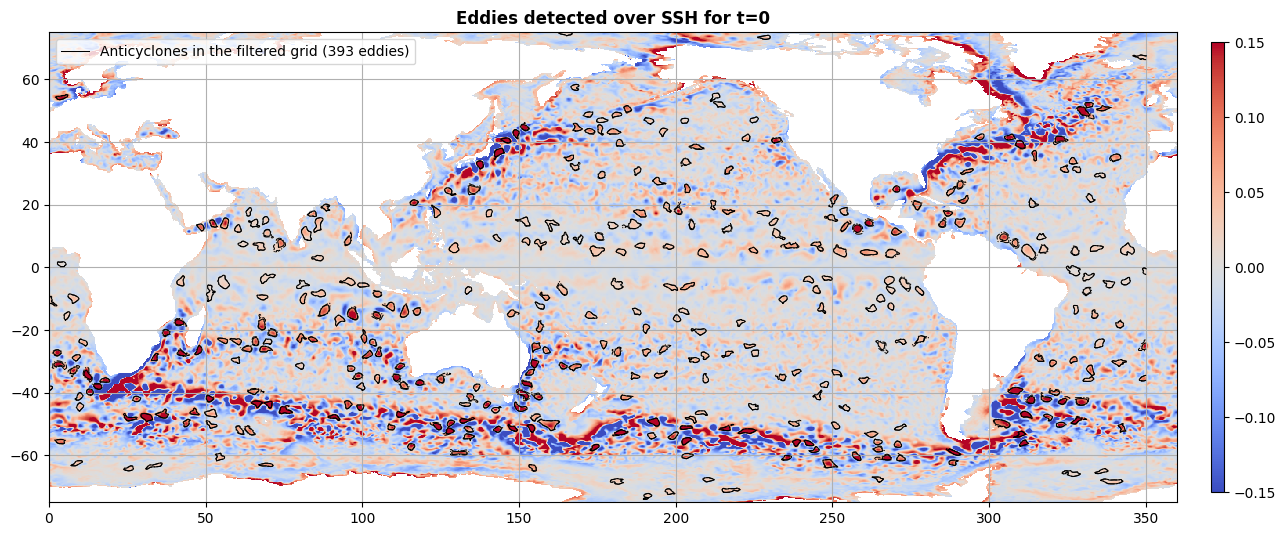

In [14]:
ax = start_axes("Eddies detected over SSH for t=1")
m = g0.display(ax, "ssh", vmin=-0.15, vmax=0.15)
a0.display(
    ax,
    lw=0.75,
    label="Anticyclones in the filtered grid ({nb_obs} eddies)",
    ref=-10,
    color="k",
)
ax.legend()
update_axes(ax, m)

## Track Eddies


In [15]:
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.tracking import Correspondances

In [16]:
#Functions from eddy-tracking.py (aided by Malcolm Roberts)
def tracking(file_objects, previous_correspondance, eddy_type, zarr=False, nb_obs_min=10, raw=True, cmin=0.05, virtual=4):
    # We run a tracking with a tracker which uses contour overlap, on first time step
    output_dir = os.path.dirname(previous_correspondance)
    class_kw = dict(cmin=cmin)
    if not os.path.isfile(previous_correspondance):
        c = Correspondances(
            datasets=file_objects, class_method=AreaTracker, 
            class_kw=class_kw, virtual=virtual
        )
        c.track()
        c.prepare_merging()
    else:
        c = Correspondances(
            datasets=file_objects, class_method=AreaTracker, 
            class_kw=class_kw, virtual=virtual,
            previous_correspondance=previous_correspondance
        )
        c.track()
        c.prepare_merging()
        c.merge()

    new_correspondance = previous_correspondance[:-3]+'_new.nc'
    with Dataset(new_correspondance, "w") as h:
        c.to_netcdf(h)

    try:
        # test can read new file, and then move to replace old file
        nc = Dataset(new_correspondance, 'r')
        os.rename(new_correspondance, previous_correspondance)
    except:
        raise Exception('Error opening new correspondance file '+new_correspondance)

    write_obs_files(c, raw, output_dir, zarr, eddy_type, nb_obs_min)
    

def write_obs_files(c, raw, output_dir, zarr, eddy_type, nb_obs_min):
    kw_write = dict(path=output_dir, zarr_flag=zarr, sign_type=eddy_type)

    fout = os.path.join(output_dir, eddy_type+'_untracked.nc')
    c.get_unused_data(raw_data=raw).write_file(
        filename=fout
    )

    short_c = c._copy()
    short_c.shorter_than(size_max=nb_obs_min)
    short_track = short_c.merge(raw_data=raw)

    if c.longer_than(size_min=nb_obs_min) is False:
        long_track = short_track.empty_dataset()
    else:
        long_track = c.merge(raw_data=raw)

    # We flag obs
    if c.virtual:
        long_track["virtual"][:] = long_track["time"] == 0
        long_track.normalize_longitude()
        long_track.filled_by_interpolation(long_track["virtual"] == 1)
        short_track["virtual"][:] = short_track["time"] == 0
        short_track.normalize_longitude()
        short_track.filled_by_interpolation(short_track["virtual"] == 1)

    print("Longer track saved have %d obs", c.nb_obs_by_tracks.max())
    print(
        "The mean length is %d observations for long track",
        c.nb_obs_by_tracks.mean(),
    )

    fout = os.path.join(output_dir, eddy_type+'_tracks.nc')
    long_track.write_file(filename=fout)
    fout = os.path.join(output_dir, eddy_type+'_short.nc')
    short_track.write_file(
        #filename="%(path)s/%(sign_type)s_track_too_short.nc", **kw_write
        filename=fout
    )



In [17]:
yrrng=datearr[0].year
tracker_dir=outdir+'tracks/'
if not os.path.exists(tracker_dir):
    os.makedirs(tracker_dir)

nb_obs_min = 10 # minimum of 10 points in track to be considered a long trajectory
raw = False # 
cmin = 0.05 # minimum contour
virtual = 4 # number of consecutive timesteps with missing detection allowed
class_kw = dict(cmin=cmin)
zarr = False


In [18]:
eddy_type='anticyclonic'
previous_correspondance = os.path.join(tracker_dir, eddy_type+'_correspondance.nc')
search = os.path.join(outdir+'eddyID_'+eddy_type+'_'+str(yrrng)+'????.nc')
print('search files ',search)
file_objects = sorted(glob.glob(search))
tracking(file_objects, previous_correspondance, eddy_type, zarr=zarr, nb_obs_min=nb_obs_min, raw=raw, cmin=cmin)


search files  /scratch/b/b382615/eerie-control-1950/gr025//eddytrack/eddyID_anticyclonic_2010????.nc
Longer track saved have %d obs 365
The mean length is %d observations for long track 32.016639704183035


In [19]:
eddy_type='cyclonic'  #need to include all changes with eddy_type
previous_correspondance = os.path.join(tracker_dir, eddy_type+'_correspondance.nc')
search = os.path.join(outdir+'eddyID_'+eddy_type+'_'+str(yrrng)+'????.nc')
print('search files ',search)
file_objects = sorted(glob.glob(search))
tracking(file_objects, previous_correspondance, eddy_type, zarr=zarr, nb_obs_min=nb_obs_min, raw=raw, cmin=cmin)


search files  /scratch/b/b382615/eerie-control-1950/gr025//eddytrack/eddyID_cyclonic_2010????.nc
Longer track saved have %d obs 344
The mean length is %d observations for long track 29.43650593284524


## High-pass filter SSH fields to composite SSH anomalies within Eddies

In [20]:
varname='ssh'

print('High pass filter daily '+varname+' for year='+str(datearr[0].year))

wavelength=700

High pass filter daily ssh for year=2010


In [21]:
smdatadir=datadir+varname+'/sm'+str(int(wavelength))+'km/'
if not os.path.exists(smdatadir):
        os.makedirs(smdatadir)

def besselhighpass(ncfile, varname, date):
    wavelength=700  #choice of spatial cutoff for high pass filter in km
    step_ht=0.005 #intervals to search for closed contours (5mm in this case)
    g = RegularGridDataset(None, "lon", "lat", centered=True, nc4file=ncfile)
    if varname=='rho':
        g.bessel_high_filter('rhopoto', wavelength, order=1)
    else:
        g.bessel_high_filter(varname, wavelength, order=1) #perfroms only on 1 time index
    
    smdatadir=datadir+varname+'/sm'+str(int(wavelength))+'km/'
    
    if varname=='to' or varname=='so' or varname=='rho':
        zidx=1
        g.write(smdatadir+'/'+str(zidx)+'_'+date.strftime('%Y%m%d')+'_hp'+str(wavelength)+'.nc')
    else:
        g.write(smdatadir+'/'+date.strftime('%Y%m%d')+'_hp'+str(int(wavelength))+'.nc')


In [25]:
# Parallel function wrapper to the for-loop 
def delayed_filter_and_save(date,tt):
    # Load data from xarray into netcdf4 type
    da_ssh = ds_subset[varname].isel(time=tt)
    da_netcdf = Dataset('in-mem-file', mode='r', memory=da_ssh.to_netcdf())
    
    #print('High pass filter of '+varname+' for '+date.strftime('%Y%m%d'))
    besselhighpass(da_netcdf, varname, date)


In [ ]:
# Filter & Make all Composites in parallel
#   For some (presumably memory-related reason) this works better with ThreadPool than ProcessPool...
with ThreadPoolExecutor(max_workers=n_cpu) as executor:
    results = list(executor.map(delayed_filter_and_save, datearr, range(len(datearr))))

## Extract eddies along track for a given region, e.g. Agulhas leakage
For Agulhas leakage region, track the eddies, get track IDs where eddy last more than 60 days. \
Along the identified tracks, gather 2.5x2.5deg around eddy center and save. 



In [27]:
rgn='AR'
mindays=60 # min number of days for tracked eddy

# eddy_type='cyclonic'
eddy_type='anticyclonic'

wavelength=700
dlon=2.5
dlat=2.5
res=0.25
npts=int(dlon/res) #number of points from centre


In [28]:
dscorres = xr.open_dataset(tracker_dir+eddy_type+'_correspondance.nc')
dstracks = xr.open_dataset(tracker_dir+eddy_type+'_tracks.nc')
dsshort = xr.open_dataset(tracker_dir+eddy_type+'_short.nc')
dsuntrack = xr.open_dataset(tracker_dir+eddy_type+'_untracked.nc')


In [29]:
#Get desired region [Agulhas rings and leakage]
ARidx = np.argwhere((dstracks.latitude.values<=-30) & (dstracks.latitude.values>=-45) & (dstracks.longitude.values>0) & (dstracks.longitude.values<25))

#Get track IDs for Agulhas rings, remove all duplicates
ARtrackid=np.array(sorted(list(set(dstracks.track.values[ARidx].squeeze()))))
print('Track IDs=',ARtrackid)

#Get number of obs for each track for Agulhas rings
trackIDs=dstracks.track.values
tracklen=[]
for ii in range(trackIDs.max()+1):
    tracklen.append(len(np.argwhere(trackIDs == ii)))
lentrack=np.array(tracklen)[ARtrackid]
print('No. of obs for each tracked ID =',lentrack)

#Remove tracks with less than minimum number of days 
newARtrackid=np.delete(ARtrackid,np.r_[np.argwhere(lentrack<mindays)])
print('Track IDs that last more than ',mindays,' days=',newARtrackid)
lentrack=np.array(tracklen)[newARtrackid]
print('No. of obs for each tracked ID =',lentrack)
del(tracklen)


Track IDs= [   2    7   10   91  119  206  344  506  610  715  727  730  782  807
  828  914  915  985 1091 1181 1182 1184 1218 1364 1418 1428 1477 1667
 1751 1752 1771 1893 1963 1985 2028 2038 2039 2177 2215 2307 2308 2458
 2485 2605 2639 2744 2753 2818 2836 2902 2993 3086 3109 3178 3202 3278
 3304 3317 3338 3511 3525 3631 3638 3644 3673 3728 3762 3827 3904 3944
 4004 4040 4094 4161 4181 4205]
No. of obs for each tracked ID = [ 19  19  52  79 125  31  12  51  17  16 312  25 128  44  18  26  47  25
  47  32  14  28  68  46  15  60  72  54  36  14  41  21  10  33  29  14
  13  49  28  58  23  15  21  20  63  61  19  21  75  14  33  12  49  18
  67  13  96  96  13  19  77  30  11  17  32  13  25  16  12  35  13  13
  29  24  22  20]
Track IDs that last more than  60  days= [  91  119  727  782 1218 1428 1477 2639 2744 2836 3202 3304 3317 3525]
No. of obs for each tracked ID = [ 79 125 312 128  68  60  72  63  61  75  67  96  96  77]


In [30]:
def geteddy_alongtrack(dmvarfile,varname,loncen,latcen,dlon=2.5,dlat=2.5,npts=npts):
    npts2=npts*2
    loncen=round(loncen,2)
    latcen=round(latcen,2)
    dsvar=xr.open_dataset(dmvarfile)
    if varname=='rho':
        FIELD=dsvar['rhopoto']
    else:
        FIELD=dsvar[varname]
    lonmin=round(loncen-dlon,2)
    lonmax=round(loncen+dlon,2)
    latmin=round(latcen-dlat,2)
    latmax=round(latcen+dlat,2)
    print('eddy center='+str(loncen)+','+str(latcen))
    print('lonmin='+str(lonmin)+', lonmax='+str(lonmax)+', latmin='+str(latmin)+', latmax='+str(latmax))
    if (lonmin < 0) & (lonmax < 0):
        FIELDcomp=FIELD.sel(lon=slice(lonmin+360,lonmax+360),lat=slice(latmin,latmax))
    elif (lonmin < 0) & (lonmax >= 0):
        FIELDcomp=xr.concat([FIELD.sel(lon=slice(lonmin+360,360),lat=slice(latmin,latmax)),FIELD.sel(lon=slice(0,lonmax),lat=slice(latmin,latmax))],dim='lon')
    elif (lonmax > 360):
        FIELDcomp=xr.concat([FIELD.sel(lon=slice(lonmin,360),lat=slice(latmin,latmax)),FIELD.sel(lon=slice(0,lonmax-360),lat=slice(latmin,latmax))],dim='lon')
    else:
        FIELDcomp=FIELD.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
    if np.shape(FIELDcomp.squeeze())!=(npts2,npts2):
        print(np.shape(FIELDcomp))
        print('issue with '+dmvarfile)
        FIELDcomp=FIELDcomp[:npts2,:npts2] # [:,:npts2,:npts2]
    return FIELDcomp


#Note that this extract eddy tracks but does not normalise to eddy radius
def extract_eddytrack_raw(dstracks,tridx,varname='ssh',expid='default',fq='dm',wavelength=700,dlon=2.5,dlat=2.5,res=0.25):
    npts=int(dlon/res)
    npts2=npts*2
    alongtrackidx=np.argwhere(dstracks.track.values==tridx)
    Reff=dstracks.effective_radius.values[alongtrackidx] #in metres
    loncen=dstracks.longitude.values[alongtrackidx]
    latcen=dstracks.latitude.values[alongtrackidx]
    timearr=dstracks.time.values[alongtrackidx].flatten()
    date_arr=[]
    FIELDcomp=[]
    for tt in range(len(timearr)):
        date_arr.append(datetime.strptime(str(timearr[tt])[:10], '%Y-%m-%d'))
        date=date_arr[tt]
        # print('Extracting for '+date.strftime('%Y%m%d'))
        #Get high pass filtered classified data
        #outdir=scratch+expid+'/'+gridspec+'/eddytrack/'
        smdatadir=datadir+varname+'/sm'+str(int(wavelength))+'km/'
        if varname=='rho' or varname=='to':
            dmvarfile=smdatadir+'/'+'1_'+date.strftime('%Y%m%d')+'_hp'+str(wavelength)+'.nc'
        else:
            dmvarfile=smdatadir+'/'+date.strftime('%Y%m%d')+'_hp'+str(wavelength)+'.nc'
        FIELDcomp.append(geteddy_alongtrack(dmvarfile,varname,loncen[tt][0],latcen[tt][0],dlon=dlon,dlat=dlat,npts=npts))
        del(dmvarfile)

    for ii in range(len(FIELDcomp)):
        if np.shape(FIELDcomp[ii].squeeze())!=(npts2,npts2):
            print(np.shape(FIELDcomp[ii].squeeze()))
            # print('issue with track#'+str(alongtrackidx))
        FIELDcomp[ii]=FIELDcomp[ii].assign_coords(lat=np.arange(-npts,npts)*res,lon=np.arange(-npts,npts)*res)
    
    return alongtrackidx, date_arr, FIELDcomp, FIELDcomp[0].attrs

#Note it is not normalized to eddy radius
def create_eddycomp_dataset(SSHcomp,date_arr,npts,res,SSHattrs,tridx,alongtrackidx,dstracks):
    compSSH=xr.DataArray(data=np.array(SSHcomp).squeeze(),
                 coords={'time':date_arr, 'y':np.arange(-npts,npts)*res, 'x':np.arange(-npts,npts)*res},
                 dims=['time','y','x'],name='ssh',attrs=SSHattrs)
    dsSSH=compSSH.to_dataset()
    # dsSSH=dsSSH.assign({'eddytrackID':tridx})
    cpts=dstracks.uavg_profile.shape[1]
    dsSSH=dsSSH.merge(xr.DataArray(data=tridx,name='eddytrackID',attrs={'long name':'ID of eddy track'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=alongtrackidx.flatten(),coords={'time':date_arr},dims=['time'],name='track'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.longitude.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='lon',attrs={'long name':'longitude of eddy centre'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.latitude.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='lat',attrs={'long name':'latitude of eddy centre'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.effective_radius.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='effective_radius',attrs={'long name':'Effective radius of eddy'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.effective_area.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='effective_area',attrs={'long name':'Effective area of eddy'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.amplitude.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='amplitude',attrs={'long name':'Amplitude of eddy'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.time.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='date_time',attrs={'long name':'date and time in datetime64'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.observation_number.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='n',attrs={'long name':'days since first detection'}))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.uavg_profile.values[alongtrackidx].squeeze(),
                                   coords={'time':date_arr,'contour':np.arange(0,cpts)},dims=['time','contour'],name='uavg_profile'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.speed_average.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='speed_average'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.speed_area.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='speed_area'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.effective_contour_longitude.values[alongtrackidx].squeeze(),
                                   coords={'time':date_arr,'contour':np.arange(0,cpts)},dims=['time','contour'],name='contour_lon_e'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.effective_contour_latitude.values[alongtrackidx].squeeze(),
                                   coords={'time':date_arr,'contour':np.arange(0,cpts)},dims=['time','contour'],name='contour_lat_e'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.effective_radius.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='radius_e'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.num_point_e.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='num_point_e'))
    dsSSH=dsSSH.merge(xr.DataArray(data=np.array(dstracks.effective_contour_shape_error.values[alongtrackidx].flatten(),dtype='float32'),coords={'time':date_arr},dims=['time'],name='shape_error_e'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.speed_contour_longitude.values[alongtrackidx].squeeze(),
                                   coords={'time':date_arr,'contour':np.arange(0,cpts)},dims=['time','contour'],name='contour_lon_s'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.speed_contour_latitude.values[alongtrackidx].squeeze(),
                                   coords={'time':date_arr,'contour':np.arange(0,cpts)},dims=['time','contour'],name='contour_lat_s'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.speed_radius.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='radius_s'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.num_point_s.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='num_point_s'))
    dsSSH=dsSSH.merge(xr.DataArray(data=np.array(dstracks.speed_contour_shape_error.values[alongtrackidx].flatten(),dtype='float32'),coords={'time':date_arr},dims=['time'],name='shape_error_s'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.num_contours.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='nb_contour_selected'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.longitude_max.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='lon_max'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.latitude_max.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='lat_max'))
    # dsSSH=dsSSH.merge(xr.DataArray(data=eddies_area_tracker.height_external_contour[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='height_external_contour'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.inner_contour_height.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='height_inner_contour'))
    # dsSSH=dsSSH.merge(xr.DataArray(data=eddies_area_tracker.height_max_speed_contour[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='height_max_speed_contour'))
    dsSSH=dsSSH.merge(xr.DataArray(data=dstracks.cost_association.values[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='cost_association'))
    # dsSSH=dsSSH.merge(xr.DataArray(data=eddies_area_tracker.virtual[alongtrackidx].flatten(),coords={'time':date_arr},dims=['time'],name='virtual'))

    return dsSSH


#Note it is not normalized to eddy radius
def appendto_eddycomp_dataset(dsSSH,varname,FIELDcomp,date_arr,npts,res,FIELDattrs):
    dsSSH=dsSSH.merge(xr.DataArray(data=np.array(FIELDcomp).squeeze(),
                 coords={'time':date_arr, 'y':np.arange(-npts,npts)*res, 'x':np.arange(-npts,npts)*res},
                 dims=['time','y','x'],name=varname,attrs=FIELDattrs))
    return dsSSH




In [31]:
# Extract composites along track and save to file

compdir = datadir+'/composite/'
if not os.path.exists(compdir):
        os.makedirs(compdir)

# Parallel function wrapper to the for-loop
def delayed_composite_and_save(tridx):
    print('Extracting for eddy track ',tridx)
    #Extract tracked eddies
    alongtrackidx, date_arr, SSHcomp, SSHattrs = extract_eddytrack_raw(dstracks,tridx,varname='ssh',expid=expid,wavelength=wavelength,dlon=dlon,dlat=dlat,res=res)
    
    #Put SSH composite into xarray
    dsSSH=create_eddycomp_dataset(SSHcomp,date_arr,npts,res,SSHattrs,tridx,alongtrackidx,dstracks)
    #tracker_dir=outdir+'tracks/'
    fileout=compdir+rgn+'_'+eddy_type+'_'+str(dlon)+'x'+str(dlat)+'deg_trackID_'+str(tridx)+'.nc'
    dsSSH.to_netcdf(fileout)


In [33]:
# Extract composites along track and save to file in parallel
#   Similarly, for some reason this works better with ThreadPool than ProcessPool...
with ThreadPoolExecutor(max_workers=16) as executor:
    results = list(executor.map(delayed_composite_and_save, newARtrackid))

Extracting for eddy track  91
Extracting for eddy track  119
Extracting for eddy track  727
Extracting for eddy track  782
Extracting for eddy track  1218
Extracting for eddy track  1428
Extracting for eddy track  1477
Extracting for eddy track  2639
Extracting for eddy track  2744
Extracting for eddy track  2836
Extracting for eddy track  3202
Extracting for eddy track  3304
Extracting for eddy track  3317
Extracting for eddy track  3525


eddy center=3.24,-31.17
lonmin=0.74, lonmax=5.74, latmin=-33.67, latmax=-28.67
eddy center=9.73,-34.37
lonmin=7.23, lonmax=12.23, latmin=-36.87, latmax=-31.87
eddy center=7.97,-32.88
lonmin=5.47, lonmax=10.47, latmin=-35.38, latmax=-30.38
eddy center=9.89,-30.45
lonmin=7.39, lonmax=12.39, latmin=-32.95, latmax=-27.95
eddy center=21.17,-38.67
lonmin=18.67, lonmax=23.67, latmin=-41.17, latmax=-36.17
eddy center=14.48,-32.22
lonmin=11.98, lonmax=16.98, latmin=-34.72, latmax=-29.72
eddy center=15.58,-40.8
lonmin=13.08, lonmax=18.08, latmin=-43.3, latmax=-38.3
eddy center=11.81,-39.58
lonmin=9.31, lonmax=14.31, latmin=-42.08, latmax=-37.08
eddy center=7.79,-36.2
lonmin=5.29, lonmax=10.29, latmin=-38.7, latmax=-33.7
eddy center=6.91,-33.28
lonmin=4.41, lonmax=9.41, latmin=-35.78, latmax=-30.78
eddy center=16.02,-39.14
lonmin=13.52, lonmax=18.52, latmin=-41.64, latmax=-36.64
eddy center=22.11,-42.91
lonmin=19.61, lonmax=24.61, latmin=-45.41, latmax=-40.41
eddy center=10.94,-39.07
lonmin=8.44,